In [1]:
# load required packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

In [2]:
# load data
train_df = pd.read_csv('/content/drive/MyDrive/drugsComTrain_raw.tsv', sep = '\t')
test_df = pd.read_csv('/content/drive/MyDrive/drugsComTest_raw.tsv', sep = '\t')

In [3]:
# remove na values from DataFrame
train_df = train_df.dropna()
test_df = test_df.dropna()

Shape:  (160398, 7) /n
Unnamed: 0       int64
drugName        object
condition       object
review          object
rating         float64
date            object
usefulCount      int64
dtype: object /n
   Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my li

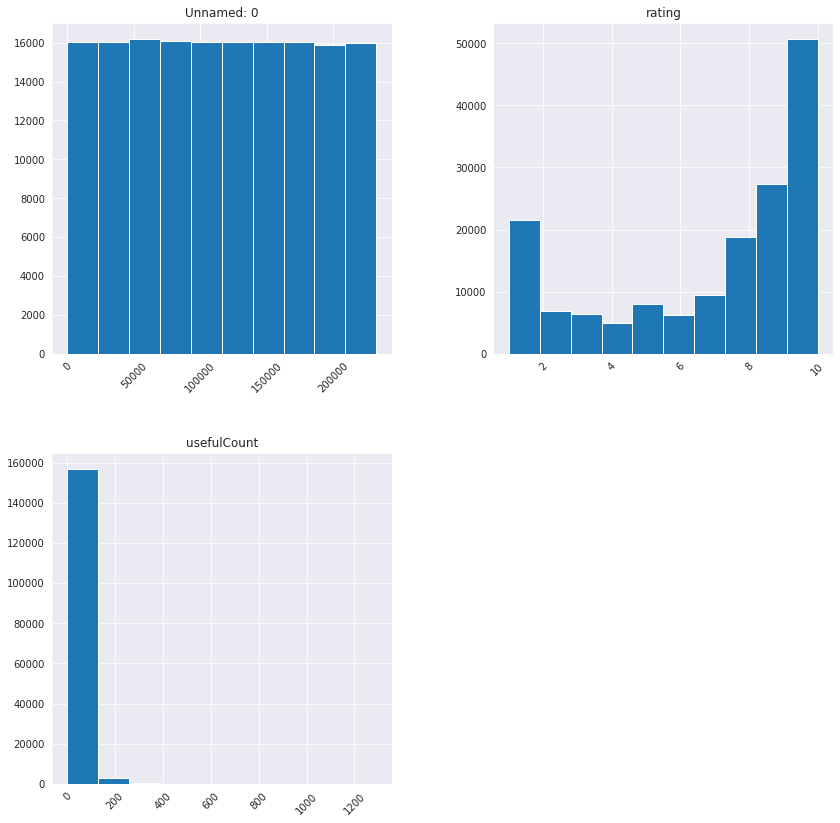

              drugName      condition  review           date
count           160398         160398  160398         160398
unique            3431            884  112105           3579
top     Levonorgestrel  Birth Control  "Good"  March 1, 2016
freq              3631          28788      33            146


In [4]:
# exploration
def explore(df):
    print("Shape: ", df.shape, "/n")
    print(df.dtypes, "/n")
    print(df.head(), "/n")
    # numeric data statistics
    print(df.describe())
    df.hist(figsize=(14,14), xrot=45)
    plt.show()
    # categorical data statistics
    print(df.describe(include = 'object'))
    for column in df.select_dtypes(include = 'object'):
        if df[column].nunique() < 10:
            sns.countplot(y = column, data = df)
            plt.show()
            plt.savefig('{}_dist.png'.format(column))


explore(train_df)

In [5]:
# obtain counts for conditions
condition_counts = train_df['condition'].value_counts()
print(condition_counts[condition_counts > 1000])

Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                    1244
O

In [6]:
# reduce the number of classes to anything with more than 1000 reviews
condition_counts_1000 = condition_counts[condition_counts > 1000]

print(len(condition_counts_1000))

counts_1000_list = list()
for idx, name in enumerate(condition_counts_1000.index.tolist()):
  counts_1000_list.append(name)

train_df = train_df[train_df['condition'].isin(counts_1000_list)]
test_df = test_df[test_df['condition'].isin(counts_1000_list)]

print(train_df['review'].shape)

32
(110121,)


In [7]:
print(counts_1000_list)

['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne', 'Bipolar Disorde', 'Insomnia', 'Weight Loss', 'Obesity', 'ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure', 'Vaginal Yeast Infection', 'Abnormal Uterine Bleeding', 'Bowel Preparation', 'ibromyalgia', 'Smoking Cessation', 'Migraine', 'Anxiety and Stress', 'Major Depressive Disorde', 'Constipation', 'Panic Disorde', 'Chronic Pain', 'Migraine Prevention', 'Urinary Tract Infection', 'Muscle Spasm', 'Osteoarthritis', 'Generalized Anxiety Disorde', 'Erectile Dysfunction', 'Opiate Dependence', 'Irritable Bowel Syndrome']


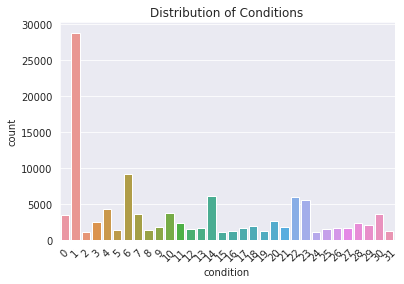

In [8]:
# visualiztions
fig, ax = plt.subplots(1, 1)
ax = sns.countplot(x = 'condition', data = train_df)
ax.set_title('Distribution of Conditions')
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
fig.show()
fig.savefig('condition_dist.png')

In [9]:
# set data and labels
x_train = train_df['review']
x_test = test_df['review']
y_train = train_df['condition']
y_test = test_df['condition']

In [12]:
# labels to one hot endoced
def prepare_targets(y_train, y_test):
  one_hot = LabelBinarizer()
  one_hot.fit(y_train)
  y_train = np.argmax(one_hot.transform(y_train), axis = 1)
  y_test_one_hot = one_hot.transform(y_test)
  y_test = np.argmax(one_hot.transform(y_test), axis = 1)
  y_test_rev = one_hot.inverse_transform(y_test_one_hot)
  label_list = one_hot.classes_
  return y_train, y_test, y_test_one_hot, y_test_rev, label_list

y_train, y_test, y_test_one_hot, y_test_rev, label_list = prepare_targets(y_train, y_test)

In [ ]:
# create weights for classes
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

weights = dict(enumerate(class_weights))
print(weights)

{0: 1.0172276825302986, 1: 1.6418326574427482, 2: 0.6158341535433071, 3: 0.5828728404471545, 4: 2.0693212567648827, 5: 0.814697265625, 6: 0.11953874010004169, 7: 1.851146449704142, 8: 2.3651417525773195, 9: 2.1575431034482757, 10: 0.37945542507442936, 11: 1.347408476898982, 12: 1.3971909257003654, 13: 3.1687672651933703, 14: 2.9564271907216493, 15: 1.4826718009478672, 16: 0.9369129458208549, 17: 3.3937684911242605, 18: 2.1414320161792157, 19: 2.0314529220779223, 20: 2.4354432059447984, 21: 2.7663032556270095, 22: 0.9644846552690582, 23: 3.1893246061167746, 24: 2.7774667070217918, 25: 0.5600132221318145, 26: 2.3522086466165413, 27: 1.9333040730337079, 28: 2.614955357142857, 29: 1.5133162928759893, 30: 0.9535276392352452, 31: 1.921430067001675}


In [ ]:
# baseline model; all predictions birth control
count_bc = condition_counts['Birth Control']
base_acc = count_bc/len(y_train)
print(base_acc)

0.26142152722913886


In [16]:
# vectorize text
vocab_size = 1500
review_len_max = 200
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = review_len_max)

# develop vocabulary
encoder.adapt(x_train.values)

# vectorize text
x_train = encoder(x_train)
x_test = encoder(x_test)

In [ ]:
print('Training input shape: ', x_train.shape)
print(len(x_train))
print(len(x_train[0]))
print(x_train[0].shape)
print('Test input shape: ', x_test.shape)
print(len(x_test))
print(len(x_test[0]))
print(x_test[0].shape)

Training input shape:  (110121, 200)
110121
200
(200,)
Test input shape:  (36827, 200)
36827
200
(200,)


In [ ]:
print(y_train.shape)

(110121,)


In [ ]:
# classifiying with tf.keras RNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size + 1, output_dim = 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 16, dropout = 0.5, recurrent_dropout = 0.0, unroll = False)),
    tf.keras.layers.Dense(32, activation = 'softmax')
]
)

# compile model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = 'Adam',
              metrics = ['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          24016     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
Total params: 29,296
Trainable params: 29,296
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# test model
history = model.fit(x = x_train, y = y_train,
        epochs = 50,
        batch_size = 50,
        validation_split = 0.2,
        class_weight = weights,
    )

Epoch 1/50
1762/1762 [==============================] - 68s 20ms/step - loss: 3.2001 - acc: 0.0731 - val_loss: 2.5739 - val_acc: 0.2742
Epoch 2/50
1762/1762 [==============================] - 34s 19ms/step - loss: 2.6470 - acc: 0.2520 - val_loss: 2.1638 - val_acc: 0.1754
Epoch 3/50
1762/1762 [==============================] - 34s 19ms/step - loss: 2.3106 - acc: 0.2120 - val_loss: 1.9747 - val_acc: 0.2762
Epoch 4/50
1762/1762 [==============================] - 34s 20ms/step - loss: 2.0920 - acc: 0.2397 - val_loss: 1.8783 - val_acc: 0.2587
Epoch 5/50
1762/1762 [==============================] - 34s 19ms/step - loss: 1.9465 - acc: 0.2668 - val_loss: 1.7931 - val_acc: 0.3133
Epoch 6/50
1762/1762 [==============================] - 34s 19ms/step - loss: 1.8344 - acc: 0.3125 - val_loss: 1.7338 - val_acc: 0.3572
Epoch 7/50
1762/1762 [==============================] - 33s 19ms/step - loss: 1.7504 - acc: 0.3560 - val_loss: 1.5732 - val_acc: 0.4047
Epoch 8/50
1762/1762 [==========================

In [ ]:
# save model
model.save('drug_review_rnn_50.h5')

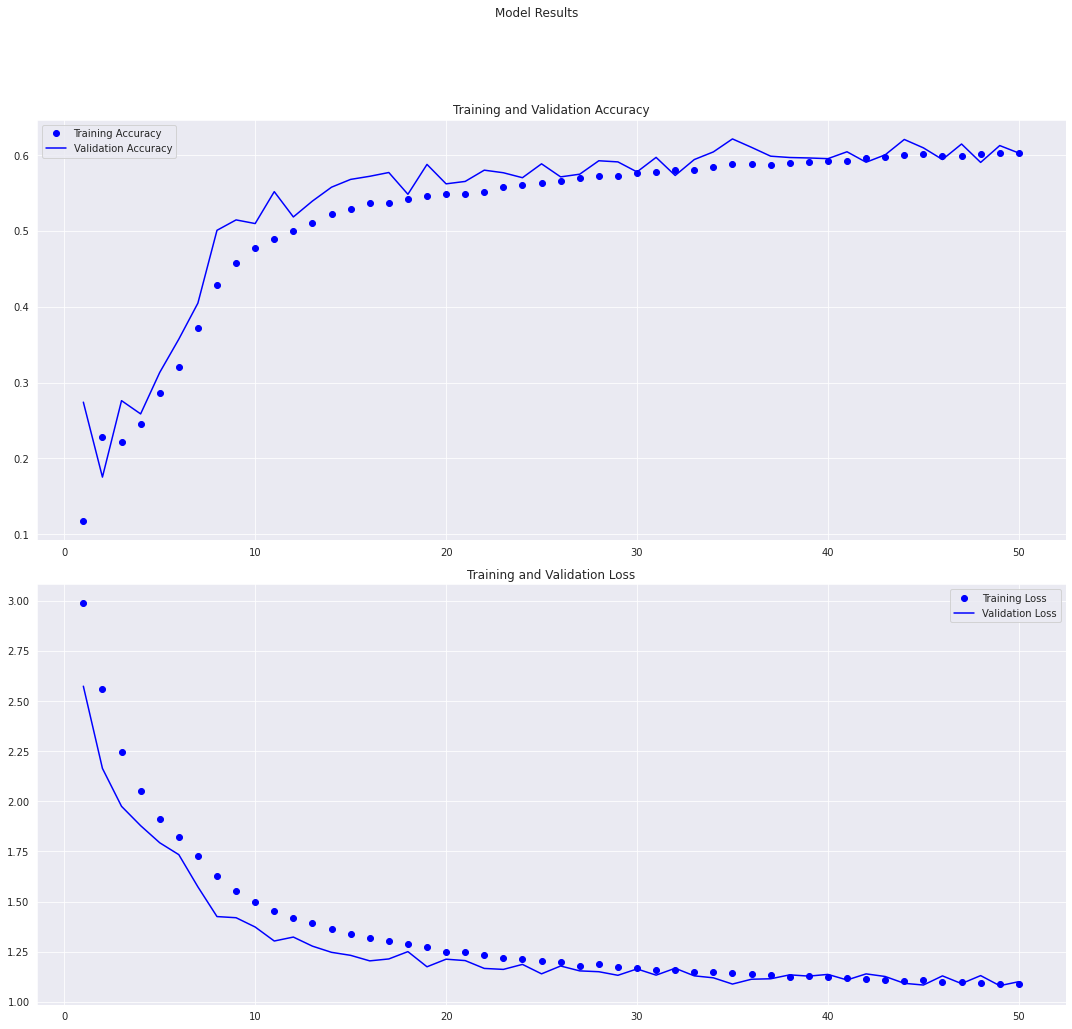

In [ ]:
# model results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15,15))
fig.suptitle('Model Results')
ax0.plot(epochs, acc, 'bo', label = 'Training Accuracy')
ax0.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
ax0.set_title('Training and Validation Accuracy')
ax0.legend()

ax1.plot(epochs, loss, 'bo', label = 'Training Loss')
ax1.plot(epochs, val_loss, 'b', label = 'Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

fig.savefig('model_results.png')

In [ ]:
# model performance
predictions = model.predict(x_test)

In [ ]:
print(predictions[0])
print(y_test[0])
print(y_test_one_hot[0])
print(y_test_rev[0])

[4.1943714e-03 5.3141492e-05 1.1367062e-04 9.5583566e-02 2.2228974e-01
 1.9638129e-02 1.8428185e-03 7.2395586e-08 2.5014702e-05 5.0075510e-06
 2.4951330e-01 7.3006345e-06 3.9542447e-06 1.4613361e-06 1.5919979e-01
 1.8198247e-04 1.3924406e-03 4.0000530e-05 2.0378804e-01 6.9832919e-07
 7.5372423e-05 1.2797008e-06 2.0408104e-04 6.0204049e-05 4.9668624e-06
 5.3810249e-06 4.0609650e-02 6.3067378e-04 3.0860517e-06 4.8659804e-06
 1.6989521e-04 3.5602206e-04]
10
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Depression


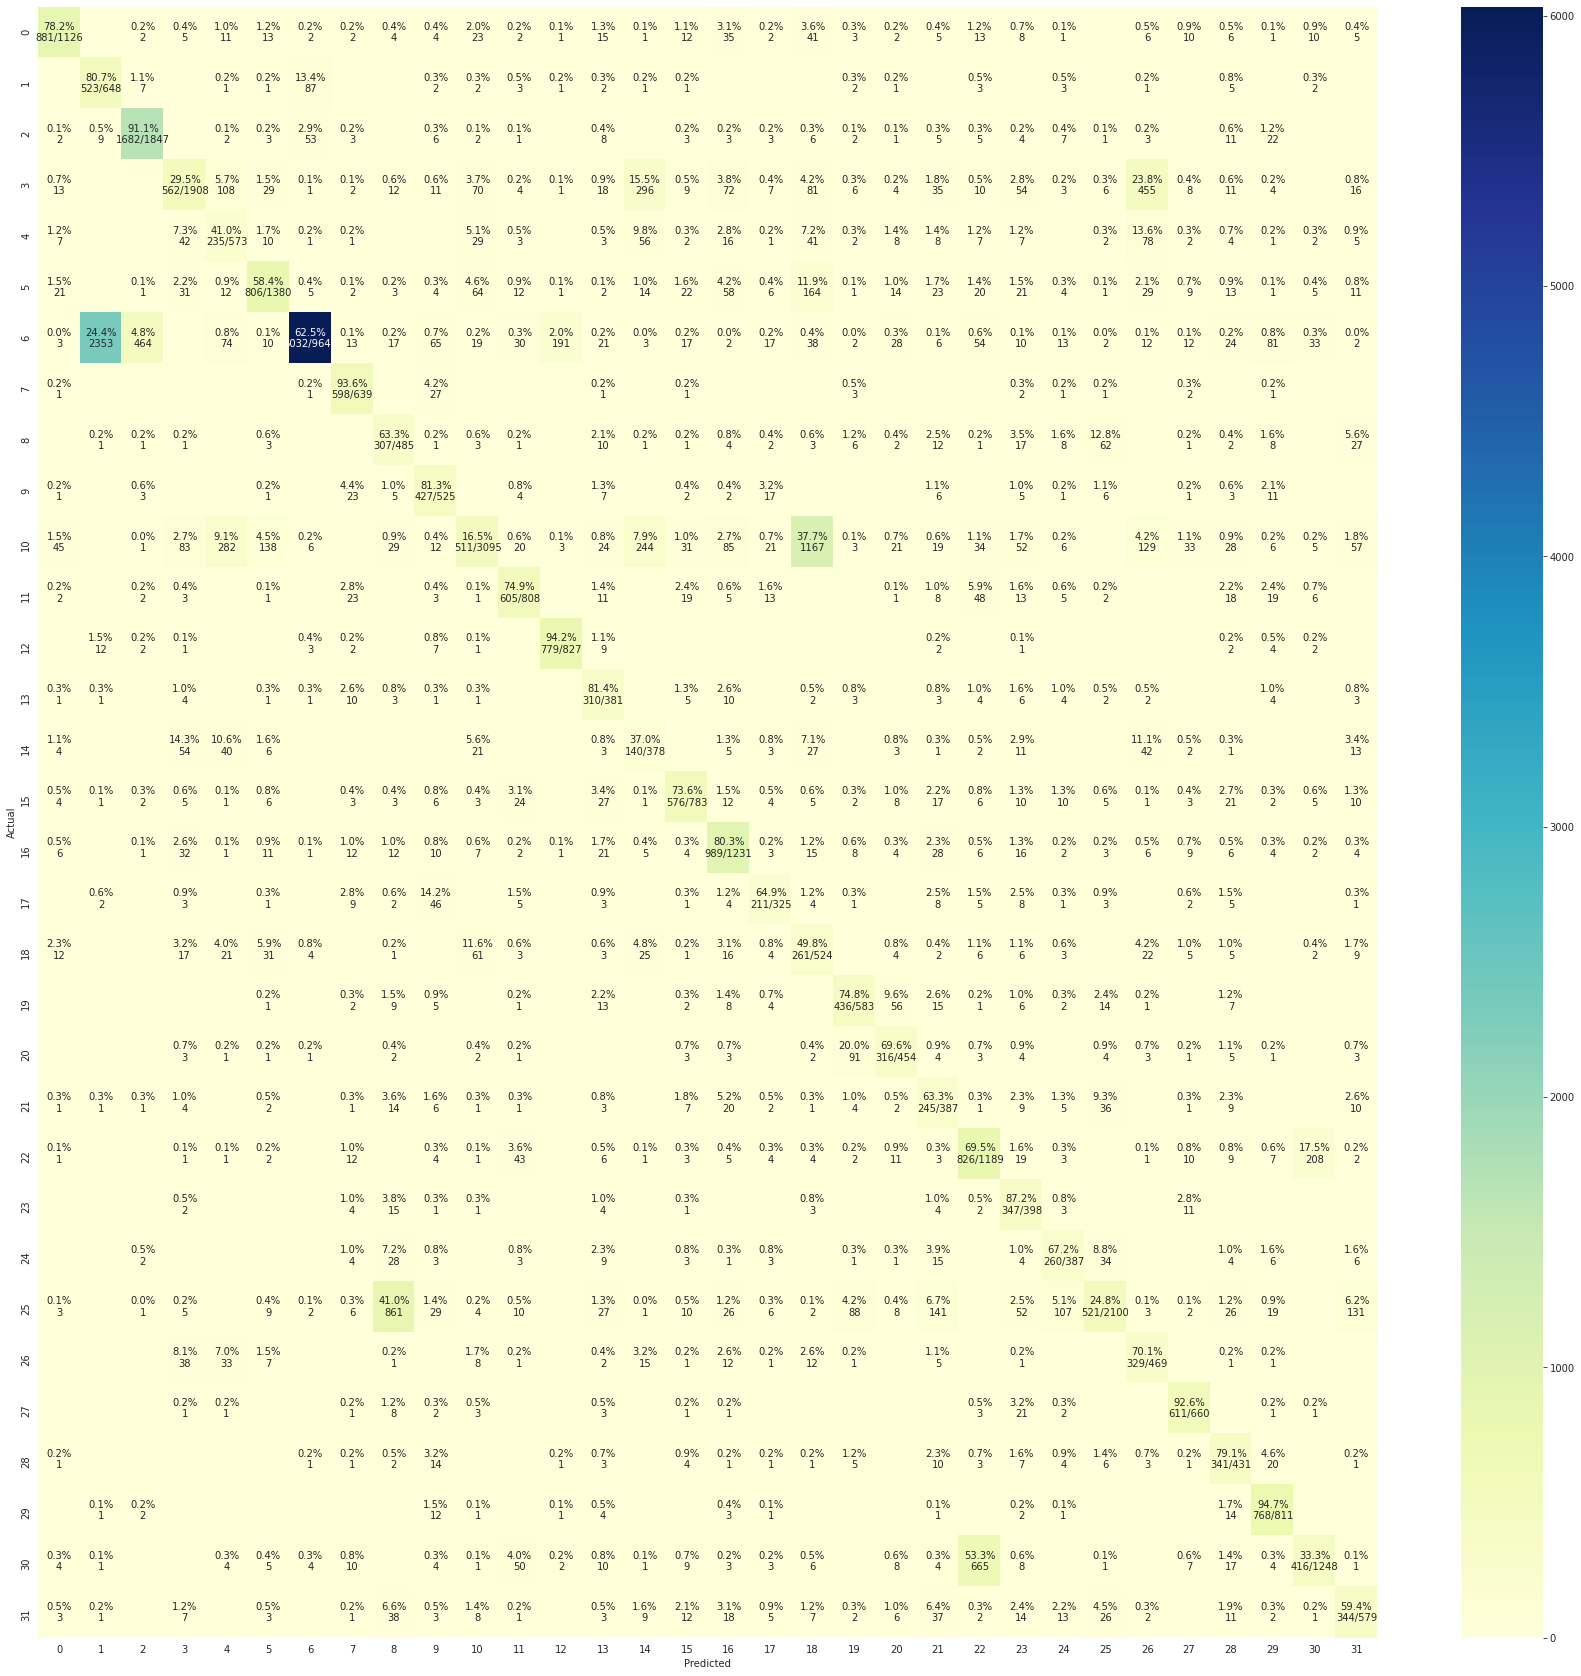

In [ ]:
# build confusion matrix
def plot_cm(y_true, y_pred, figsize = (30, 30)):
    cm = confusion_matrix(y_true, y_pred, labels = np.unique(y_true))
    cm_sum = np.sum(cm, axis = 1, keepdims = True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index = np.unique(y_true), columns = np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot = annot, fmt = '', ax = ax)
    fig.savefig('confusion_matrix.png')

plot_cm(y_test_one_hot.argmax(axis = 1), predictions.argmax(axis = 1))

In [17]:
# load saved model
new_model = tf.keras.models.load_model('/content/drug_review_rnn_50.h5')

# make new predictions
new_predictions = new_model.predict(x_test)

In [18]:
print(y_test[0])
print(y_test_one_hot[0])
print(y_test_rev[0])

10
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Depression


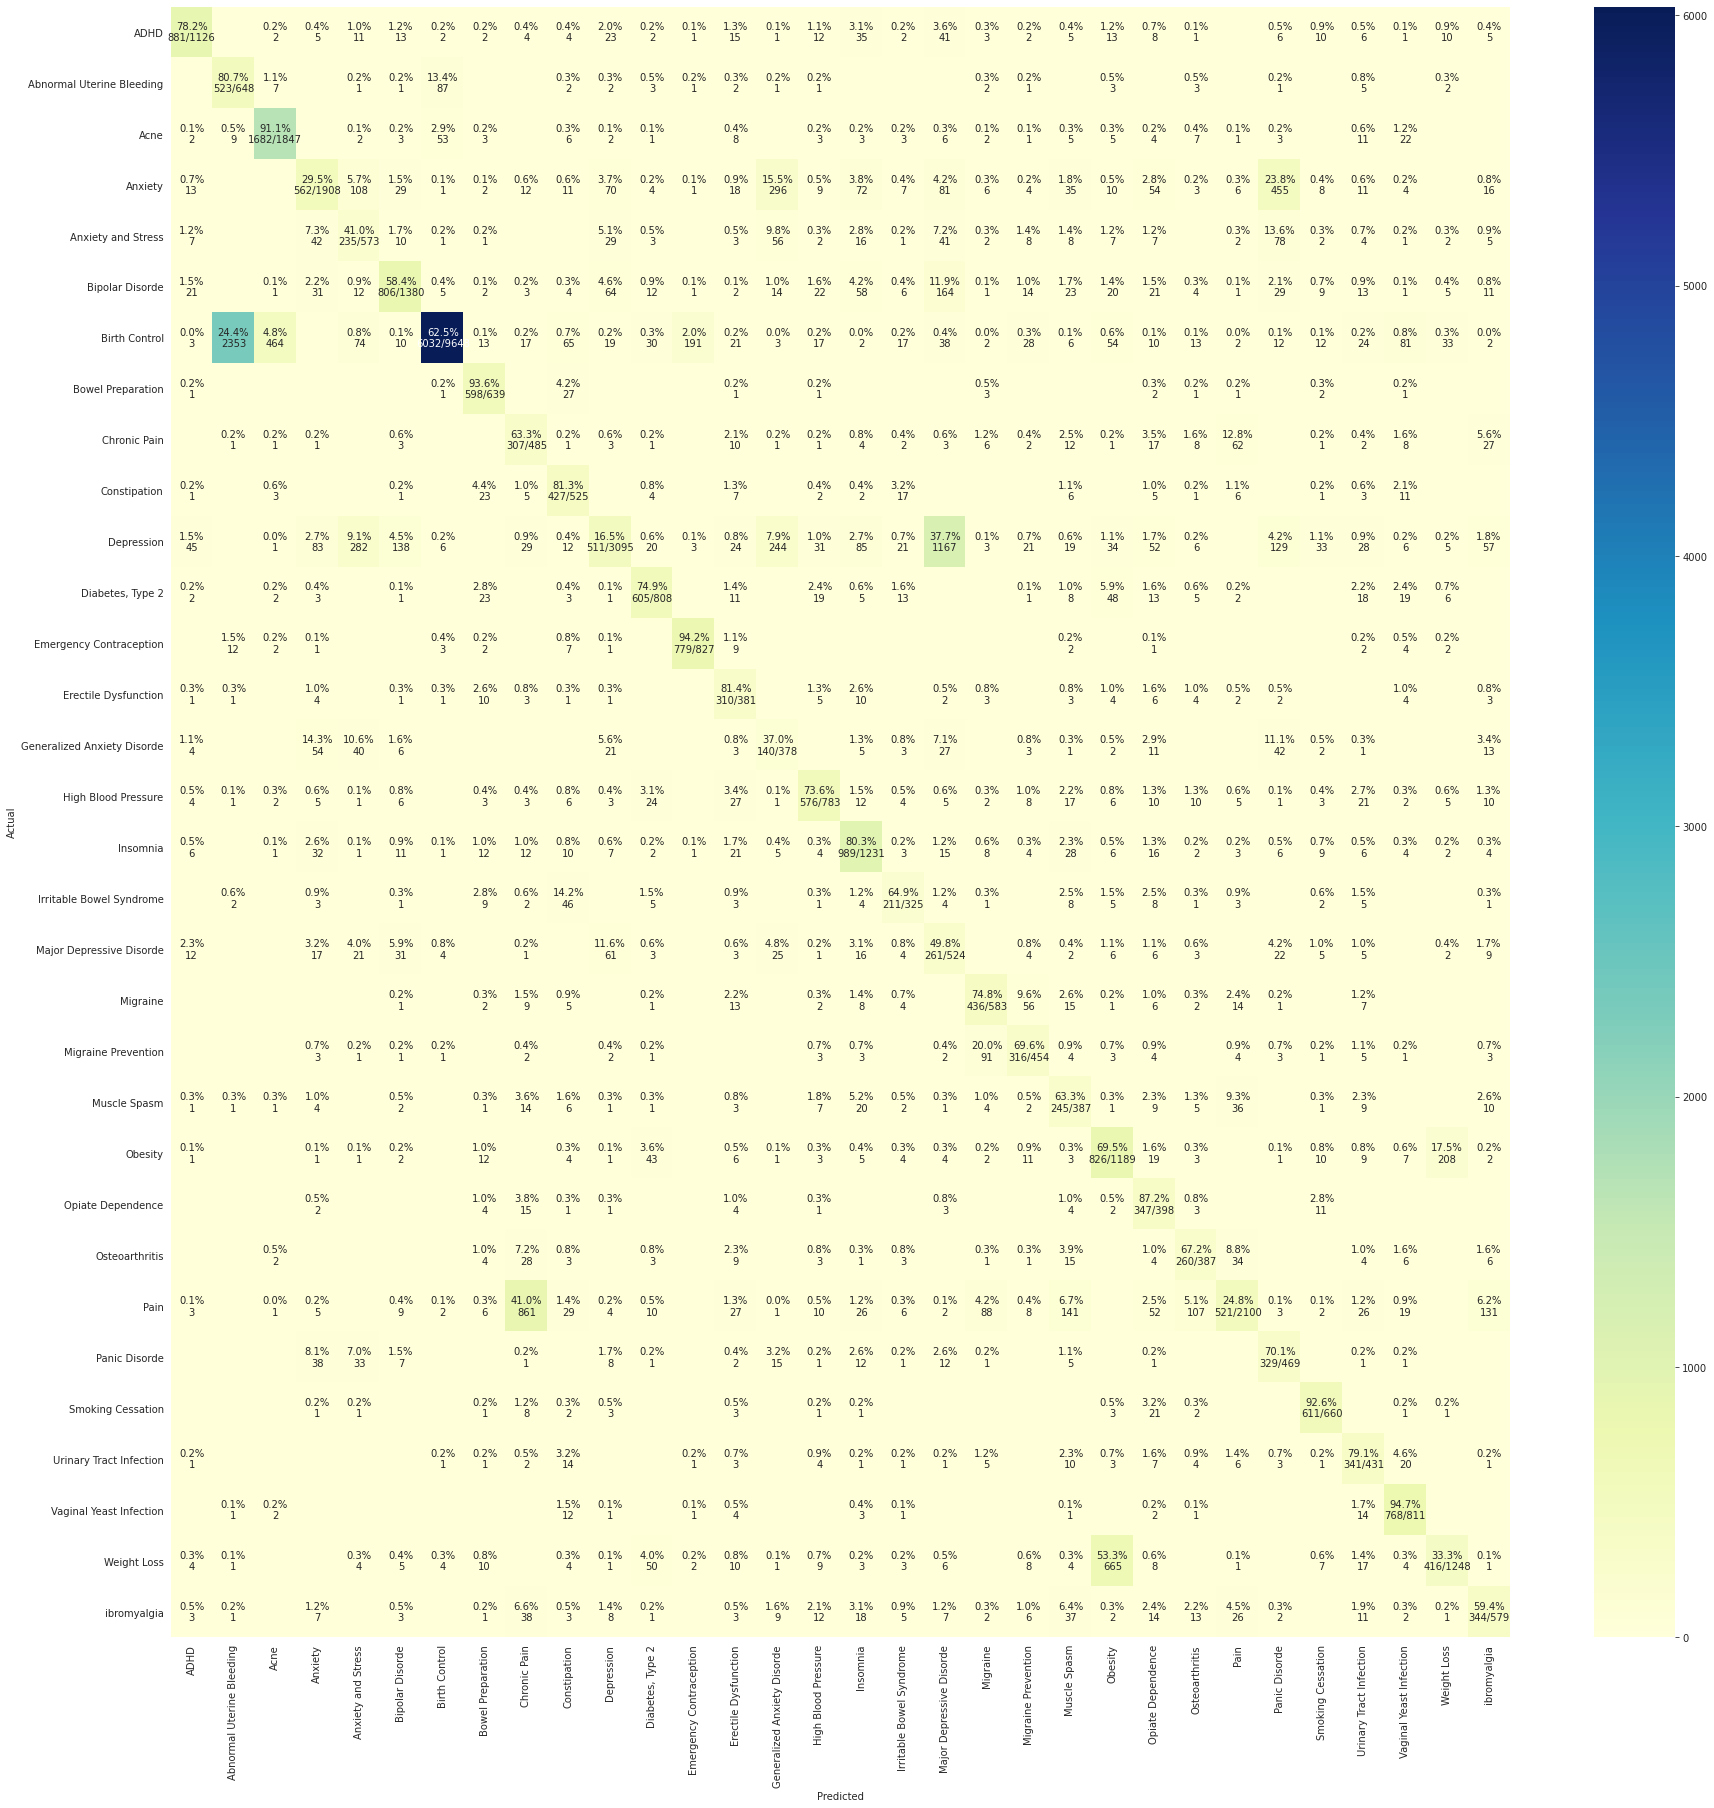

In [19]:
# build confusion matrix
def plot_cm(y_true, y_pred, figsize = (30, 30)):
    cm = confusion_matrix(y_true, y_pred, labels = np.unique(y_true))
    cm_sum = np.sum(cm, axis = 1, keepdims = True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index = np.unique(y_true), columns = np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot = annot, fmt = '', ax = ax, xticklabels = label_list, yticklabels = label_list)
    fig.savefig('confusion_matrix.png')

plot_cm(y_test_one_hot.argmax(axis = 1), new_predictions.argmax(axis = 1))

In [ ]:
# model accuracy
accuracy_metric = accuracy_score(y_test, new_predictions.argmax(axis = 1))

print('Accuracy: ', accuracy_metric)

Accuracy:  0.6026828142395525
